# 04 - Avaliação do Modelo
## Tech Challenge Fase 4 - Previsão de Ações com LSTM

Este notebook demonstra a avaliação detalhada do modelo LSTM treinado.

In [1]:
import sys
sys.path.append('..')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from src.utils.metrics import calculate_metrics, plot_predictions

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## 1. Carregar Modelo e Dados

In [2]:
# Carregar modelo
try:
    model = tf.keras.models.load_model('../models/saved/lstm_model.keras', compile=False)
    print("✅ Modelo carregado: lstm_model.keras")
except:
    model = tf.keras.models.load_model('../models/saved/lstm_model.h5', compile=False)
    print("✅ Modelo carregado: lstm_model.h5")

# Carregar scaler
with open('../models/saved/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
print("✅ Scaler carregado")

# Carregar métricas salvas
try:
    with open('../models/saved/metrics.json', 'r') as f:
        saved_metrics = json.load(f)
    print("✅ Métricas carregadas")
    print(f"\nMétricas do treinamento:")
    for key, value in saved_metrics.items():
        print(f"  {key}: {value}")
except:
    print("⚠️  Arquivo metrics.json não encontrado")
    saved_metrics = None

2025-11-04 19:49:12.161040: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


✅ Modelo carregado: lstm_model.keras
✅ Scaler carregado
✅ Métricas carregadas

Métricas do treinamento:
  mae: 14.19593244168808
  rmse: 15.452482134346248
  mape: 7.637035368290081
  train_loss: 0.008213426917791367
  val_loss: 0.03575143590569496
  epochs_trained: 58


In [3]:
# Carregar dados de teste
X_test = np.load('../data/processed/X_test.npy')
y_test = np.load('../data/processed/y_test.npy')

print(f"Dados de teste carregados:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

Dados de teste carregados:
  X_test: (143, 60, 5)
  y_test: (143,)


## 2. Fazer Previsões

In [4]:
# Fazer previsões
y_pred_scaled = model.predict(X_test, verbose=0)

# Desnormalizar
n_features = scaler.n_features_in_

y_pred_temp = np.zeros((len(y_pred_scaled), n_features))
y_pred_temp[:, 3] = y_pred_scaled.reshape(-1)

y_test_temp = np.zeros((len(y_test), n_features))
y_test_temp[:, 3] = y_test.reshape(-1)

y_pred = scaler.inverse_transform(y_pred_temp)[:, 3]
y_true = scaler.inverse_transform(y_test_temp)[:, 3]

print("✅ Previsões realizadas e desnormalizadas")
print(f"  Valores reais: [{y_true.min():.2f}, {y_true.max():.2f}]")
print(f"  Valores previstos: [{y_pred.min():.2f}, {y_pred.max():.2f}]")

✅ Previsões realizadas e desnormalizadas
  Valores reais: [165.68, 196.93]
  Valores previstos: [162.71, 171.82]


## 3. Calcular Métricas de Avaliação

In [5]:
# Calcular métricas
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

# Erro médio percentual
mean_price = np.mean(y_true)
mae_percentage = (mae / mean_price) * 100

print("\n📊 MÉTRICAS DE AVALIAÇÃO DO MODELO")
print("=" * 50)
print(f"\n1. Erro Absoluto Médio (MAE):")
print(f"   {mae:.4f} ({mae_percentage:.2f}% do preço médio)")
print(f"\n2. Raiz do Erro Quadrático Médio (RMSE):")
print(f"   {rmse:.4f}")
print(f"\n3. Erro Quadrático Médio (MSE):")
print(f"   {mse:.4f}")
print(f"\n4. Erro Percentual Absoluto Médio (MAPE):")
print(f"   {mape:.2f}%")
print(f"\n5. Coeficiente de Determinação (R²):")
print(f"   {r2:.4f}")
print(f"\n6. Preço Médio Real:")
print(f"   ${mean_price:.2f}")
print("\n" + "=" * 50)


📊 MÉTRICAS DE AVALIAÇÃO DO MODELO

1. Erro Absoluto Médio (MAE):
   14.1959 (7.77% do preço médio)

2. Raiz do Erro Quadrático Médio (RMSE):
   15.4525

3. Erro Quadrático Médio (MSE):
   238.7792

4. Erro Percentual Absoluto Médio (MAPE):
   7.64%

5. Coeficiente de Determinação (R²):
   -2.6834

6. Preço Médio Real:
   $182.81



## 4. Visualizações Detalhadas

### 4.1 Previsões vs Valores Reais

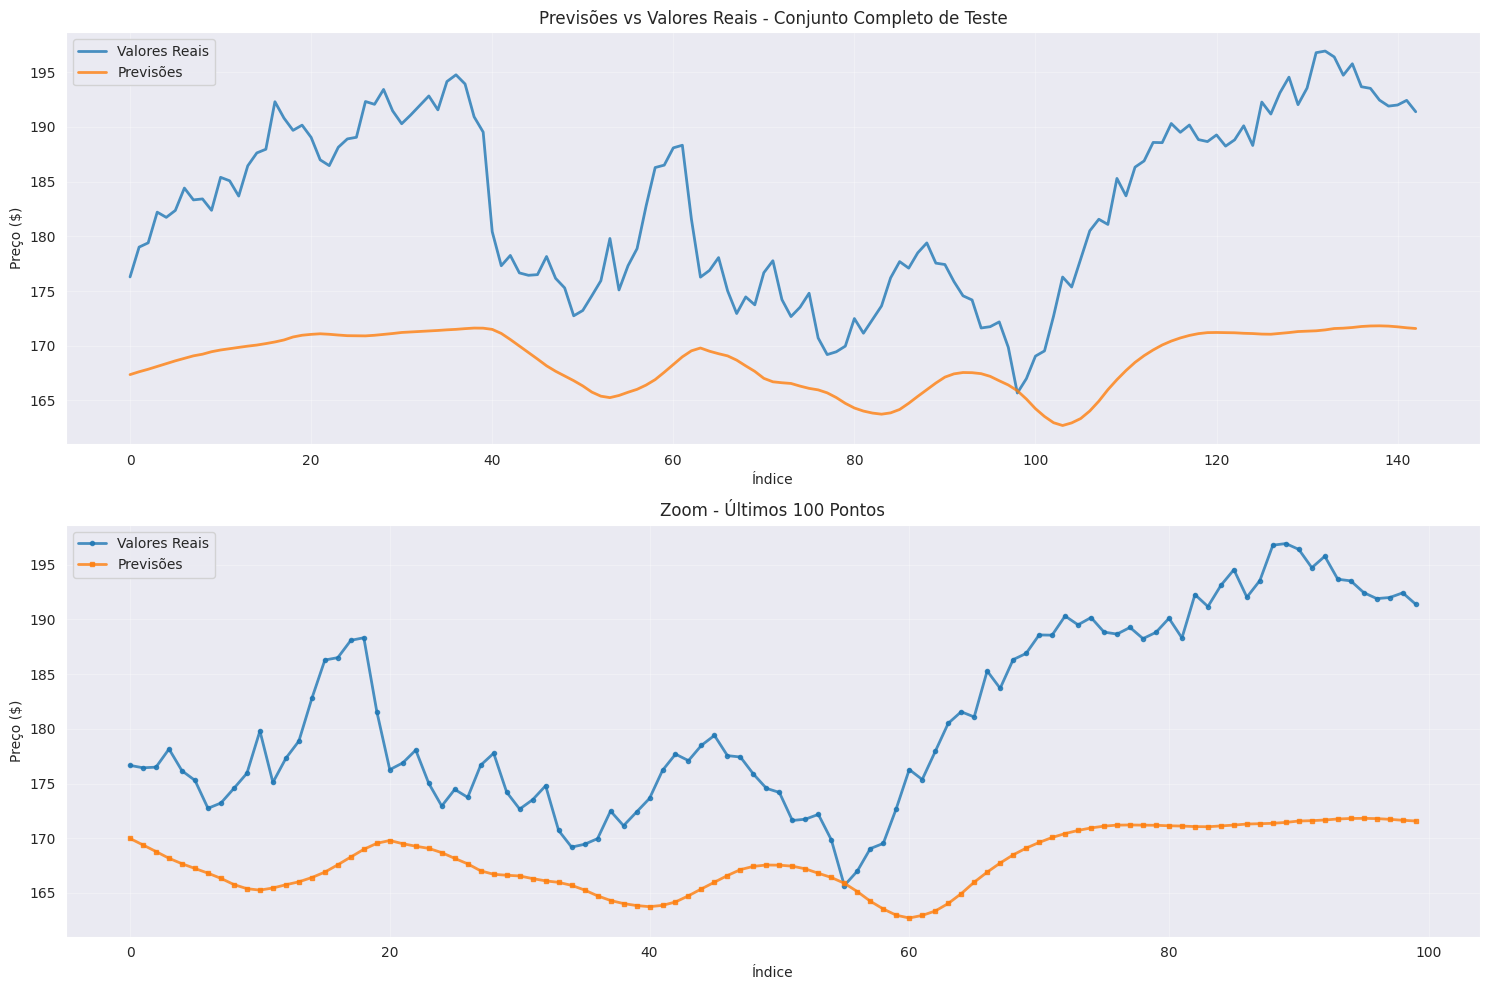

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Gráfico completo
axes[0].plot(y_true, label='Valores Reais', linewidth=2, alpha=0.8)
axes[0].plot(y_pred, label='Previsões', linewidth=2, alpha=0.8)
axes[0].set_title('Previsões vs Valores Reais - Conjunto Completo de Teste')
axes[0].set_xlabel('Índice')
axes[0].set_ylabel('Preço ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Zoom nos últimos 100 pontos
n_zoom = min(100, len(y_true))
axes[1].plot(range(n_zoom), y_true[-n_zoom:], label='Valores Reais', 
            linewidth=2, marker='o', markersize=3, alpha=0.8)
axes[1].plot(range(n_zoom), y_pred[-n_zoom:], label='Previsões', 
            linewidth=2, marker='s', markersize=3, alpha=0.8)
axes[1].set_title(f'Zoom - Últimos {n_zoom} Pontos')
axes[1].set_xlabel('Índice')
axes[1].set_ylabel('Preço ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Scatter Plot - Previsões vs Reais

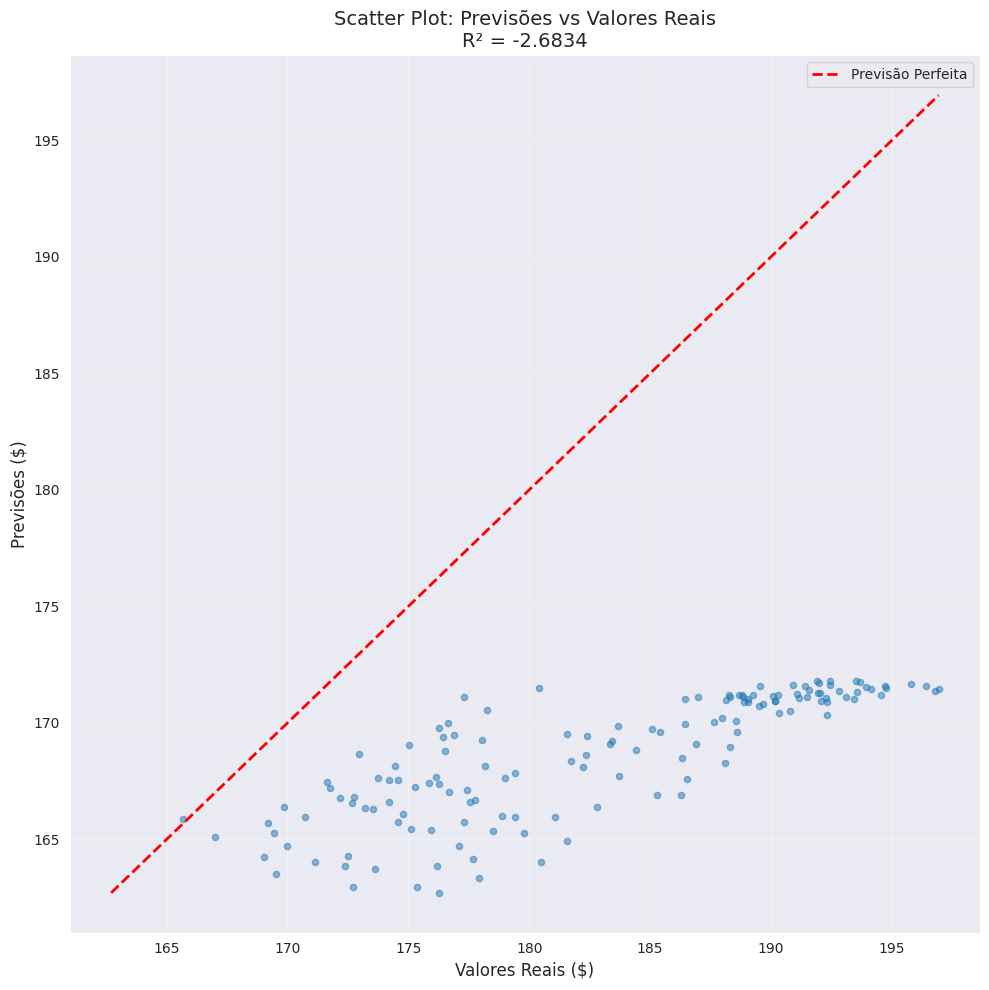

In [7]:
plt.figure(figsize=(10, 10))

plt.scatter(y_true, y_pred, alpha=0.5, s=20)

# Linha de regressão perfeita
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Previsão Perfeita')

plt.xlabel('Valores Reais ($)', fontsize=12)
plt.ylabel('Previsões ($)', fontsize=12)
plt.title(f'Scatter Plot: Previsões vs Valores Reais\nR² = {r2:.4f}', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.3 Análise de Erros

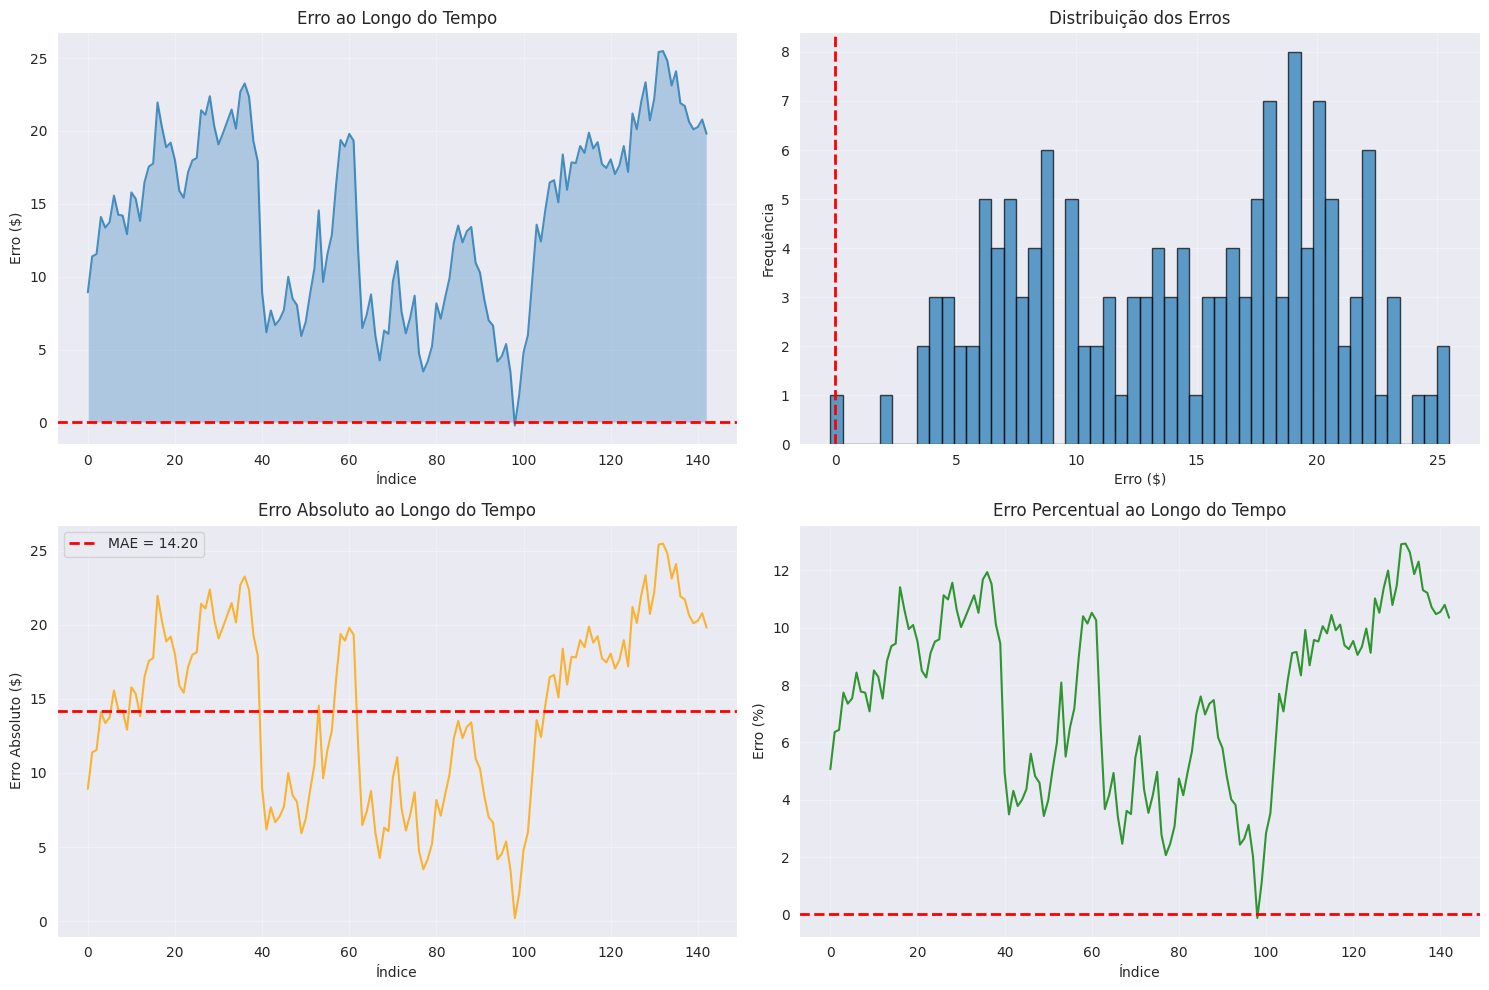


📊 ESTATÍSTICAS DOS ERROS
Erro médio: 14.1930
Desvio padrão: 6.1105
Erro mínimo: -0.2107
Erro máximo: 25.4814

Erro percentual médio: 7.64%
Desvio padrão %: 3.04%


In [8]:
# Calcular erros
errors = y_true - y_pred
abs_errors = np.abs(errors)
percent_errors = (errors / y_true) * 100

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Erro ao longo do tempo
axes[0, 0].plot(errors, linewidth=1.5, alpha=0.8)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].fill_between(range(len(errors)), errors, 0, alpha=0.3)
axes[0, 0].set_title('Erro ao Longo do Tempo')
axes[0, 0].set_xlabel('Índice')
axes[0, 0].set_ylabel('Erro ($)')
axes[0, 0].grid(True, alpha=0.3)

# Distribuição dos erros
axes[0, 1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_title('Distribuição dos Erros')
axes[0, 1].set_xlabel('Erro ($)')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].grid(True, alpha=0.3)

# Erro absoluto ao longo do tempo
axes[1, 0].plot(abs_errors, linewidth=1.5, color='orange', alpha=0.8)
axes[1, 0].axhline(y=mae, color='r', linestyle='--', linewidth=2, label=f'MAE = {mae:.2f}')
axes[1, 0].set_title('Erro Absoluto ao Longo do Tempo')
axes[1, 0].set_xlabel('Índice')
axes[1, 0].set_ylabel('Erro Absoluto ($)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Erro percentual
axes[1, 1].plot(percent_errors, linewidth=1.5, color='green', alpha=0.8)
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_title('Erro Percentual ao Longo do Tempo')
axes[1, 1].set_xlabel('Índice')
axes[1, 1].set_ylabel('Erro (%)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas dos erros
print("\n📊 ESTATÍSTICAS DOS ERROS")
print("=" * 50)
print(f"Erro médio: {errors.mean():.4f}")
print(f"Desvio padrão: {errors.std():.4f}")
print(f"Erro mínimo: {errors.min():.4f}")
print(f"Erro máximo: {errors.max():.4f}")
print(f"\nErro percentual médio: {percent_errors.mean():.2f}%")
print(f"Desvio padrão %: {percent_errors.std():.2f}%")
print("=" * 50)

### 4.4 Análise de Resíduos

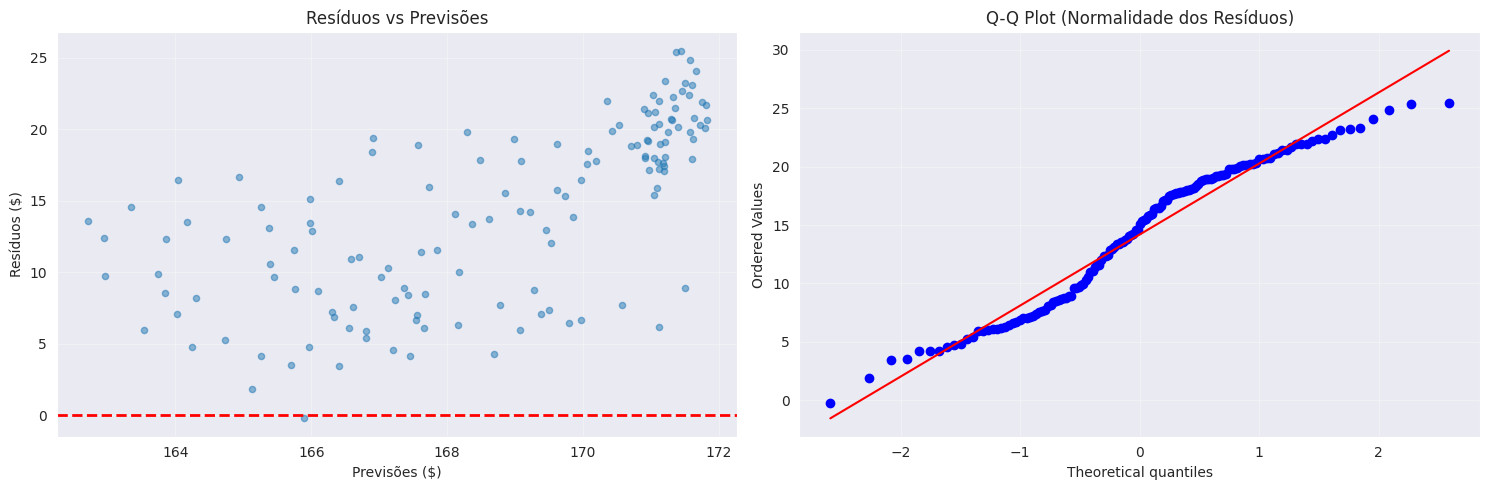

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Resíduos vs Previsões
axes[0].scatter(y_pred, errors, alpha=0.5, s=20)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Previsões ($)')
axes[0].set_ylabel('Resíduos ($)')
axes[0].set_title('Resíduos vs Previsões')
axes[0].grid(True, alpha=0.3)

# Q-Q Plot
from scipy import stats
stats.probplot(errors, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normalidade dos Resíduos)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Análise de Acurácia Direcional


📈 ACURÁCIA DIRECIONAL
Acurácia em prever a direção: 50.00%

Interpretação: O modelo acerta a direção
(subida/descida) em 50.00% dos casos.


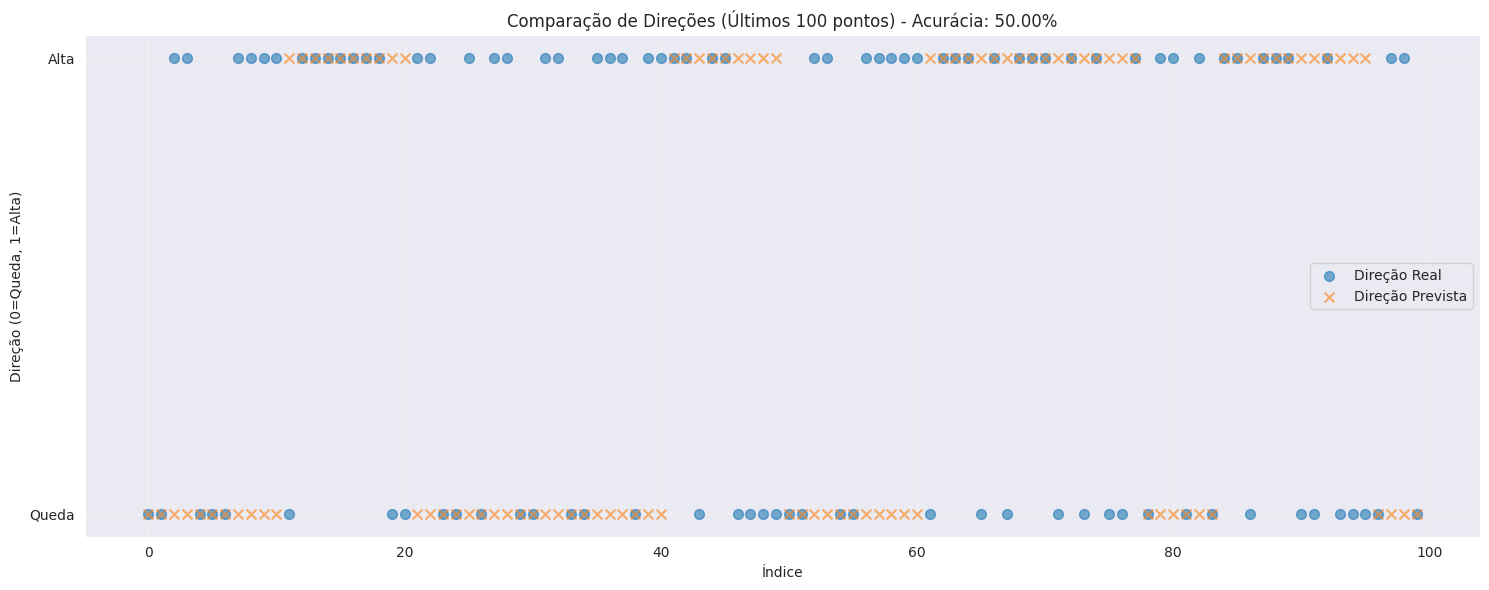

In [10]:
# Calcular direções (subida ou descida)
actual_direction = np.diff(y_true) > 0
predicted_direction = np.diff(y_pred) > 0

# Acurácia direcional
directional_accuracy = np.mean(actual_direction == predicted_direction) * 100

print(f"\n📈 ACURÁCIA DIRECIONAL")
print("=" * 50)
print(f"Acurácia em prever a direção: {directional_accuracy:.2f}%")
print(f"\nInterpretação: O modelo acerta a direção")
print(f"(subida/descida) em {directional_accuracy:.2f}% dos casos.")
print("=" * 50)

# Visualizar direções
plt.figure(figsize=(15, 6))

n_viz = min(100, len(actual_direction))
x = range(n_viz)

plt.scatter(x, actual_direction[-n_viz:], alpha=0.6, s=50, label='Direção Real', marker='o')
plt.scatter(x, predicted_direction[-n_viz:], alpha=0.6, s=50, label='Direção Prevista', marker='x')

plt.title(f'Comparação de Direções (Últimos {n_viz} pontos) - Acurácia: {directional_accuracy:.2f}%')
plt.xlabel('Índice')
plt.ylabel('Direção (0=Queda, 1=Alta)')
plt.yticks([0, 1], ['Queda', 'Alta'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Performance em Diferentes Faixas de Preço

In [11]:
# Dividir em quartis
quartiles = np.percentile(y_true, [25, 50, 75])

ranges = [
    (y_true <= quartiles[0], f"Baixo (≤${quartiles[0]:.2f})"),
    ((y_true > quartiles[0]) & (y_true <= quartiles[1]), f"Médio-Baixo (${quartiles[0]:.2f}-${quartiles[1]:.2f})"),
    ((y_true > quartiles[1]) & (y_true <= quartiles[2]), f"Médio-Alto (${quartiles[1]:.2f}-${quartiles[2]:.2f})"),
    (y_true > quartiles[2], f"Alto (>${quartiles[2]:.2f})")
]

print("\n📊 PERFORMANCE POR FAIXA DE PREÇO")
print("=" * 70)

for mask, label in ranges:
    if np.sum(mask) > 0:
        mae_range = mean_absolute_error(y_true[mask], y_pred[mask])
        rmse_range = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
        mape_range = np.mean(np.abs((y_true[mask] - y_pred[mask]) / 
                                     np.clip(np.abs(y_true[mask]), 1e-8, None))) * 100
        
        print(f"\n{label}:")
        print(f"  Pontos: {np.sum(mask)}")
        print(f"  MAE: {mae_range:.4f}")
        print(f"  RMSE: {rmse_range:.4f}")
        print(f"  MAPE: {mape_range:.2f}%")

print("\n" + "=" * 70)


📊 PERFORMANCE POR FAIXA DE PREÇO

Baixo (≤$176.18):
  Pontos: 36
  MAE: 6.5713
  RMSE: 7.0247
  MAPE: 3.79%

Médio-Baixo ($176.18-$182.78):
  Pontos: 36
  MAE: 11.4797
  RMSE: 11.8516
  MAPE: 6.41%

Médio-Alto ($182.78-$190.13):
  Pontos: 35
  MAE: 17.3673
  RMSE: 17.4347
  MAPE: 9.27%

Alto (>$190.13):
  Pontos: 36
  MAE: 21.4535
  RMSE: 21.5209
  MAPE: 11.12%



## 7. Tabela Resumo Comparativa

In [12]:
# Criar tabela resumo
summary_data = {
    'Métrica': ['MAE', 'RMSE', 'MAPE', 'R²', 'Acurácia Direcional'],
    'Valor': [
        f"{mae:.4f}",
        f"{rmse:.4f}",
        f"{mape:.2f}%",
        f"{r2:.4f}",
        f"{directional_accuracy:.2f}%"
    ],
    'Interpretação': [
        f"Erro médio de ${mae:.2f}",
        f"Penaliza erros grandes",
        f"Erro percentual médio",
        f"{'Excelente' if r2 > 0.9 else 'Bom' if r2 > 0.7 else 'Razoável'} ajuste",
        f"Acerta direção em {directional_accuracy:.0f}% dos casos"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n📋 RESUMO DAS MÉTRICAS")
print("=" * 80)
print(summary_df.to_string(index=False))
print("=" * 80)


📋 RESUMO DAS MÉTRICAS
            Métrica   Valor                   Interpretação
                MAE 14.1959            Erro médio de $14.20
               RMSE 15.4525          Penaliza erros grandes
               MAPE   7.64%           Erro percentual médio
                 R² -2.6834                 Razoável ajuste
Acurácia Direcional  50.00% Acerta direção em 50% dos casos


## 8. Salvar Resultados da Avaliação

In [13]:
# Criar relatório completo
evaluation_report = {
    'metrics': {
        'mae': float(mae),
        'rmse': float(rmse),
        'mse': float(mse),
        'mape': float(mape),
        'r2': float(r2),
        'directional_accuracy': float(directional_accuracy)
    },
    'error_statistics': {
        'mean': float(errors.mean()),
        'std': float(errors.std()),
        'min': float(errors.min()),
        'max': float(errors.max())
    },
    'data_info': {
        'test_samples': int(len(y_test)),
        'price_range': [float(y_true.min()), float(y_true.max())],
        'mean_price': float(mean_price)
    }
}

# Salvar relatório
with open('../models/saved/evaluation_report.json', 'w') as f:
    json.dump(evaluation_report, f, indent=4)

print("✅ Relatório de avaliação salvo em models/saved/evaluation_report.json")

# Salvar previsões
predictions_df = pd.DataFrame({
    'real': y_true,
    'predicted': y_pred,
    'error': errors,
    'abs_error': abs_errors,
    'percent_error': percent_errors
})

predictions_df.to_csv('../models/saved/predictions.csv', index=False)
print("✅ Previsões salvas em models/saved/predictions.csv")

✅ Relatório de avaliação salvo em models/saved/evaluation_report.json
✅ Previsões salvas em models/saved/predictions.csv


## 📊 Resumo Final da Avaliação

### ✅ Avaliação Completa Realizada

**Métricas Principais:**
- MAE (Mean Absolute Error)
- RMSE (Root Mean Square Error)
- MAPE (Mean Absolute Percentage Error)
- R² (Coeficiente de Determinação)
- Acurácia Direcional

**Análises Realizadas:**
1. ✅ Comparação visual: Previsões vs Valores Reais
2. ✅ Análise de erros e distribuição
3. ✅ Análise de resíduos
4. ✅ Acurácia direcional
5. ✅ Performance por faixa de preço

**Arquivos Gerados:**
- evaluation_report.json (métricas completas)
- predictions.csv (todas as previsões)

### 🎯 Próximos Passos
1. Deploy da API
2. Testes em produção
3. Monitoramento contínuo
4. Retreinamento periódico